In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import rotate
import pickle

from collections import defaultdict
import networkx as nx

from data.utils import *

In [4]:
with open('data/data.pickle', 'rb') as f:
    data_new = pickle.load(f)
    
env = data_new['env']
obj = data_new['obj']

(array([0, 1, 3, 7], dtype=int32), array([53088, 13986,  2928,  8886]))


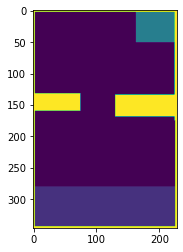

In [5]:
plt.imshow(env)
print(np.unique(env, return_counts=True))

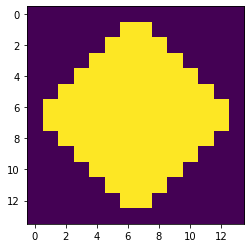

In [6]:
plt.imshow(obj)

# GRAPH RRT 

In [7]:
def distance_angle_all(point1, point2):
    return np.linalg.norm(point1[:, :2] - point2[:2], axis=1)[:, None] \
                + 20 * angle_difference(point1[:, -1], finish_point[-1])[:, None]

class GraphRRT:
    
    def __init__(self, start, end, step=75, weight=20):
        self.start = start
        self.end = end
        self.step = step
        self.weight = weight
        
        self.G = nx.DiGraph()
        self.G.add_node(0, val = tuple(self.start))
    
    def num_of_vertices(self):
        return len(self.G.nodes)
    
    def distance_angle(self, point1, point2, theta1, theta2):
        return np.linalg.norm(point1 - point2) + self.weight * angle_difference(theta1, theta2)

    def random_init(self):
        
        key = np.random.choice(range(2), p=[0.1, 0.9])
        if key:
            xnew = int(np.random.uniform(0, 346))
            ynew = int(np.random.uniform(0, 228))
            angle = 0
        
        else:
            xnew, ynew, angle = self.end
            
        return xnew, ynew, angle
    
    def find_nearest(self, random_point):
        min_distance = 1e15
        min_index = None
        
        for index, vert in enumerate(self.G.nodes):
            vert = np.array(self.G.nodes[vert]['val'])
            distance = self.distance_angle(random_point[:2], vert[:2], 
                                    random_point[-1], vert[-1])
            if distance <= min_distance:
                min_distance = distance
                min_index = index
        
        return min_index
    
    def steer(self, random_point, min_index):
        
        excess_vector_coords = random_point[:2] - np.array(self.G.nodes[min_index]['val'])[:2]
        normalize = excess_vector_coords / np.linalg.norm(excess_vector_coords)
        
        node_coords = np.array(self.G.nodes[min_index]['val'])[:2]
        delta_coords = node_coords + normalize * self.step
        delta_vector_coords = delta_coords - node_coords
          
        angle = np.array(self.G.nodes[min_index]['val'])[-1]
        new_angle = angle + angle_difference(random_point[-1], angle * np.linalg.norm(delta_vector_coords) / \
                                            np.linalg.norm(excess_vector_coords))
    
        vertex = np.hstack((delta_coords, new_angle))  
        return vertex, new_angle
        
    def rtt(self, n_iter=5):
        
        for i in range(n_iter):
            
            if not i % 200:
                print('Iteration:', i)

            random_point = self.random_init()
            
            # Find index of the closest node
            min_index = self.find_nearest(random_point)
            
            # Steer new coords
            vertex, new_angle = self.steer(random_point, min_index)   
            
            if check_collision_obj_image(
                env, 
                rotate_image(obj, new_angle), 
                np.array(self.G.nodes[min_index]['val'])[:2].astype(int),
                vertex[:2].astype(int),
                12
            ):
                continue
                
            new_vertex_index = self.num_of_vertices()
            self.G.add_node(new_vertex_index, val=tuple(vertex))
            self.G.add_edge(min_index, new_vertex_index)
            
            
    def sure_path_exists(self):
        vertices = [self.G.nodes[i]['val'] for i in range(len(self.G.nodes))]
        indices = distance_angle_all(np.array(vertices), self.end).flatten().argsort()
        for index in indices:
            if not check_collision_obj_image(
                env, 
                rotate_image(obj, vertices[index][-1]),
                np.array(vertices[index])[:2].astype(int),
                self.end[:2].astype(int),
                12
            ):
                return index
            
    def create_plan(self):
        point = self.sure_path_exists()
        plan = []
        
        if point is None:
            raise ValueError('Apparently, it is necessary to increase number of iterations.')

        while True:
            current_node = self.G.nodes[point]['val']
            plan.append(current_node)
            try:
                point = list(self.G.predecessors(point))[0]

            except IndexError:
                break
                
        return plan[::-1]

In [13]:
initial_point = np.array([200, 20, 0])
finish_point = np.array([50, 163, 0])
weight = 20 # Не нужна, ибо угол всегда 0 (оставил на всякий случай)
step = 5
g = GraphRRT(initial_point, finish_point, weight=weight, step=step)

g.rtt(200)

plan = g.create_plan()
# plotting_results(env, obj, plan, weight=weight, step=step)

Iteration: 0


In [12]:
g.G.[(0, 1)]

KeyError: (0, 1)

# ЧТОБЫ КАРТИНКУ ПОСТРОИТЬ

In [ ]:
from typing import Union

def calc_radius(n: int, d: int, coef: Union[int, float]) -> float:
    """
    @n - number of state vertices
    @d - state dimension
    @coef - size of circles
    """
    return (np.log(n) / n) ** (1 / d) * coef

def near(V, v_new, d=3):
    """
    @V - set of vertices
    @v_new - 
    
    """
    n = len(V)
    
    near_set = []
    
    radius = calc_radius(n, d)
    for vertex in V:
        distance = np.linalg.norm(vertex - v_new)
        print('Distance', distance)
        print('Radius', radius)
        if distance <= radius:
            near_set.append(vertex)
            
    return near_set

plt.figure(figsize=(12, 8))

xaxis = [x[1] for x in plan]
yaxis = [x[0] for x in plan]

verbose_step = 10
radius = calc_radius(2, 3, 30)

for i in range(len(plan)):
    if not i % verbose_step - 1:
        circle = plt.Circle((xaxis[i], yaxis[i]), radius, color='magenta', fill=False, linewidth=3)
        plt.gca().add_patch(circle)

plt.plot(xaxis, yaxis, color='white', linewidth=3)
plt.imshow(env)

plt.axis('off')

plt.show()

# plt.savefig('rrt.png', bbox_inches='tight', pad_inches=0)

# GRAPH RRBT

In [14]:
def distance_angle_all(point1, point2):
    return np.linalg.norm(point1[:, :2] - point2[:2], axis=1)[:, None] \
                + 20 * angle_difference(point1[:, -1], finish_point[-1])[:, None]

class GraphRRTBNX:
    
    def __init__(self, start, end, step=75, weight=20):
        self.start = start
        self.end = end
        self.step = step
        self.weight = weight
        
        self.G = nx.DiGraph()
        self.G.add_node(0, val = tuple(self.start))
    
    def num_of_vertices(self):
        return len(self.G.nodes)
    
    def distance_angle(self, point1, point2, theta1, theta2):
        return np.linalg.norm(point1 - point2) + self.weight * angle_difference(theta1, theta2)

    def random_init(self):
        
        key = np.random.choice(range(2), p=[0.1, 0.9])
        if key:
            xnew = int(np.random.uniform(0, 346))
            ynew = int(np.random.uniform(0, 228))
            angle = 0
        
        else:
            xnew, ynew, angle = self.end
            
        return xnew, ynew, angle
    
    def find_nearest(self, random_point):
        min_distance = 1e15
        min_index = None
        
        for index, vert in enumerate(self.G.nodes):
            vert = np.array(self.G.nodes[vert]['val'])
            distance = self.distance_angle(random_point[:2], vert[:2], 
                                    random_point[-1], vert[-1])
            if distance <= min_distance:
                min_distance = distance
                min_index = index
        
        return min_index
    
    @staticmethod
    def calc_radius(n: int, d: int = 3) -> float:
        """
        @n - number of state vertices
        @d - state dimension
        """
        return (np.log(n) / n) ** (1 / d) * 10
    
    def near(self, v_new, d = 3):
        """
        @V - set of vertices
        @v_new - new point

        """
        n = len(self.G.nodes)

        near_set = []

        radius = self.calc_radius(n, d)
        for vertex in self.G.nodes:
            vertex_coords = np.array(self.G.nodes[vertex]['val'])[:2]
            distance = np.linalg.norm(vertex_coords - v_new[:2])
            if distance <= radius:
                near_set.append(vertex)

        return near_set
    
    def find_predecessors(self, node_index):
        return list(self.G.predecessors(node_index))
    
    def steer(self, random_point, min_index):
        
        excess_vector_coords = random_point[:2] - np.array(self.G.nodes[min_index]['val'])[:2]
        normalize = excess_vector_coords / np.linalg.norm(excess_vector_coords)
        
        node_coords = np.array(self.G.nodes[min_index]['val'])[:2]
        delta_coords = node_coords + normalize * self.step
        delta_vector_coords = delta_coords - node_coords
          
        angle = np.array(self.G.nodes[min_index]['val'])[-1]
        new_angle = angle + angle_difference(random_point[-1], angle * np.linalg.norm(delta_vector_coords) / \
                                            np.linalg.norm(excess_vector_coords))
    
        vertex = np.hstack((delta_coords, new_angle))  
        return vertex, new_angle
        
    def rttb(self, n_iter=5):
        
        for i in range(n_iter):
            
            if not i % 200:
                print('Iteration:', i)

            random_point = self.random_init()
            
            # Find index of the closest node
            min_index = self.find_nearest(random_point)
            
            # Steer new coords
            vertex, new_angle = self.steer(random_point, min_index)   
            
            if check_collision_obj_image(
                env, 
                rotate_image(obj, new_angle), 
                np.array(self.G.nodes[min_index]['val'])[:2].astype(int),
                vertex[:2].astype(int),
                threshold=12 # Empiristically
            ):
                continue
                
            new_vertex_index = self.num_of_vertices()
            self.G.add_node(new_vertex_index, val=tuple(vertex))
            self.G.add_edge(min_index, new_vertex_index)
            
            near_vertices_indices = self.near(vertex)
            for index in near_vertices_indices:
                if index != new_vertex_index:
                    self.G.add_edge(index, new_vertex_index)
            
    def sure_path_exists(self):
        vertices = [self.G.nodes[i]['val'] for i in range(len(self.G.nodes))]
        indices = distance_angle_all(np.array(vertices), self.end).flatten().argsort()
        for index in indices:
            if not check_collision_obj_image(
                env, 
                rotate_image(obj, vertices[index][-1]),
                np.array(vertices[index])[:2].astype(int),
                self.end[:2].astype(int),
                threshold=12 # Empiristically
            ):
                return index
            
    def create_plan(self):
        point = self.sure_path_exists()
        plan = []
        
        if point is None:
            raise ValueError('Apparently, it is necessary to increase number of iterations.')

        while True:
            current_node = self.G.nodes[point]['val']
            plan.append(current_node)
            try:
                point = list(self.G.predecessors(point))[0]

            except IndexError:
                break
                
        return plan[::-1]

In [15]:
# env, obj, start, stop = load_data('PS2_data.npz')

initial_point = np.array([200, 20, 0])
finish_point = np.array([50, 163, 0])
weight = 20
step = 5
g = GraphRRTBNX(initial_point, finish_point, weight=weight, step=step)

g.rttb(50)

Iteration: 0


In [23]:
g.G.nodes[0]

{'val': (200, 20, 0)}

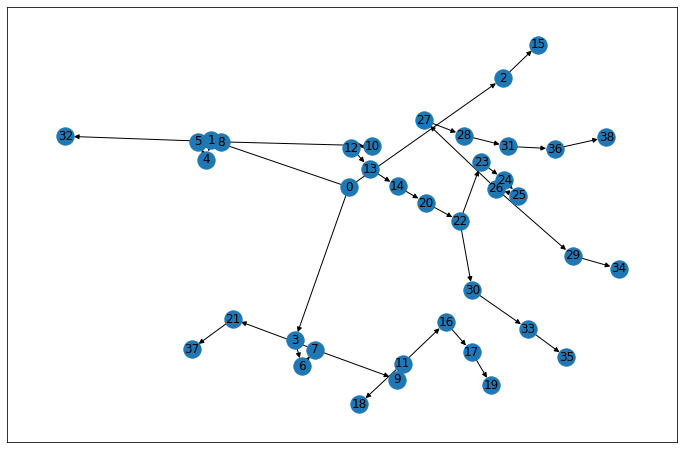

In [16]:
plt.figure(figsize=(12, 8))
nx.draw_networkx(g.G)

# NEAR

In [11]:
point = np.array([230, 50])

# Near vertices indices
g.near(point)

[]

# WHO OWNS

In [12]:
g.find_predecessors(36)

[34]

In [16]:
def trim_zeros(array):
    for axis in [0, 1]:
        mask = ~(array == 0).all(axis=axis)
        inv_mask = mask[::-1]
        start_idx = np.argmax(mask == True)
        end_idx = len(inv_mask) - np.argmax(inv_mask == True)
        if axis:
            array = array[start_idx:end_idx, :]
        else:
            array = array[:, start_idx:end_idx]
            
    return array

def create_ellipse(x_radius, y_radius, angle):
    x0 = y0 = 0.5
    num_of_pixels = 200
    
    x_radius = x_radius / num_of_pixels
    y_radius = y_radius / num_of_pixels
    
    x = np.linspace(0, 1, num_of_pixels)
    y = np.linspace(0, 1, num_of_pixels)[:, None]
    
    ellipse = ((x - x0) / x_radius) ** 2 + ((y - y0) / y_radius) ** 2 <= 1
    ellipse = ellipse.astype(float) * 5
    
    return trim_zeros(rotate_image(ellipse, angle=angle))

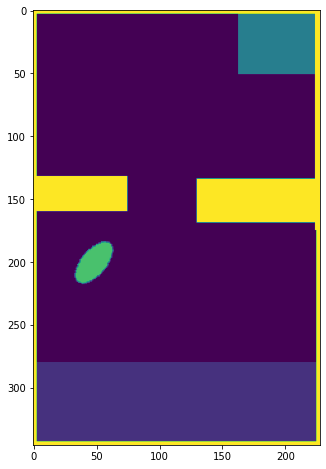

In [28]:
coords = np.array([200, 50])
ellipse = create_ellipse(10, 20, -40)

plt.figure(figsize=(12, 8))
plt.imshow(merge_images(env, ellipse, coords))

True


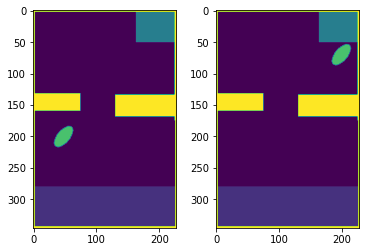

<Figure size 864x576 with 0 Axes>

In [29]:
initial_coords = np.array([200, 50])
new_coords = np.array([70, 200])

fig, ax = plt.subplots(1, 2)
plt.figure(figsize=(12, 8))

ax[0].imshow(merge_images(env, ellipse, initial_coords))
ax[1].imshow(merge_images(env, ellipse, new_coords))

print(check_collision_obj_image(
    env, 
    obj, 
    initial_coords,
    new_coords,
    threshold=12
))